### Environment setup

In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
from dataLoader import get_dataset
from model import get_model

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


### Loading data
- download the data **monet_tfrec** and **photo_tfrec** in the dataset folder.
- [config kaggle API](https://github.com/Kaggle/kaggle-api)

(-0.5, 255.5, 255.5, -0.5)

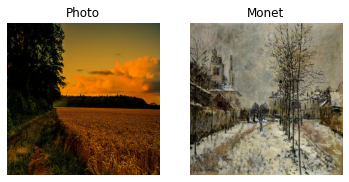

In [3]:
monet_ds, photo_ds = get_dataset()

example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)
plt.axis('off')

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)
plt.axis('off')

### Training

In [8]:
ganModel = get_model()

ganModel.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25
)

# store the model for later use
if os.path.exists('./saved_generator') == False:
    os.mkdir('./saved_generator')

ganModel.m_gen.save('./saved_generator', compile=False)

Epoch 1/25
300/300 [==============================] - 52s 119ms/step - monet_gen_loss: 4.3386 - photo_gen_loss: 4.4022 - monet_disc_loss: 0.7143 - photo_disc_loss: 0.7149
Epoch 2/25
300/300 [==============================] - 36s 120ms/step - monet_gen_loss: 3.5534 - photo_gen_loss: 3.5519 - monet_disc_loss: 0.6586 - photo_disc_loss: 0.6644
Epoch 3/25
300/300 [==============================] - 36s 120ms/step - monet_gen_loss: 3.3198 - photo_gen_loss: 3.3319 - monet_disc_loss: 0.6494 - photo_disc_loss: 0.6551
Epoch 4/25
300/300 [==============================] - 36s 120ms/step - monet_gen_loss: 3.1475 - photo_gen_loss: 3.1651 - monet_disc_loss: 0.6441 - photo_disc_loss: 0.6493
Epoch 5/25
300/300 [==============================] - 36s 120ms/step - monet_gen_loss: 3.0261 - photo_gen_loss: 3.0477 - monet_disc_loss: 0.6396 - photo_disc_loss: 0.6454
Epoch 6/25
300/300 [==============================] - 36s 120ms/step - monet_gen_loss: 2.9496 - photo_gen_loss: 2.9716 - monet_disc_loss: 0.6352 

INFO:tensorflow:Assets written to: ./saved_generator/assets


INFO:tensorflow:Assets written to: ./saved_generator/assets


### Show some reuslts

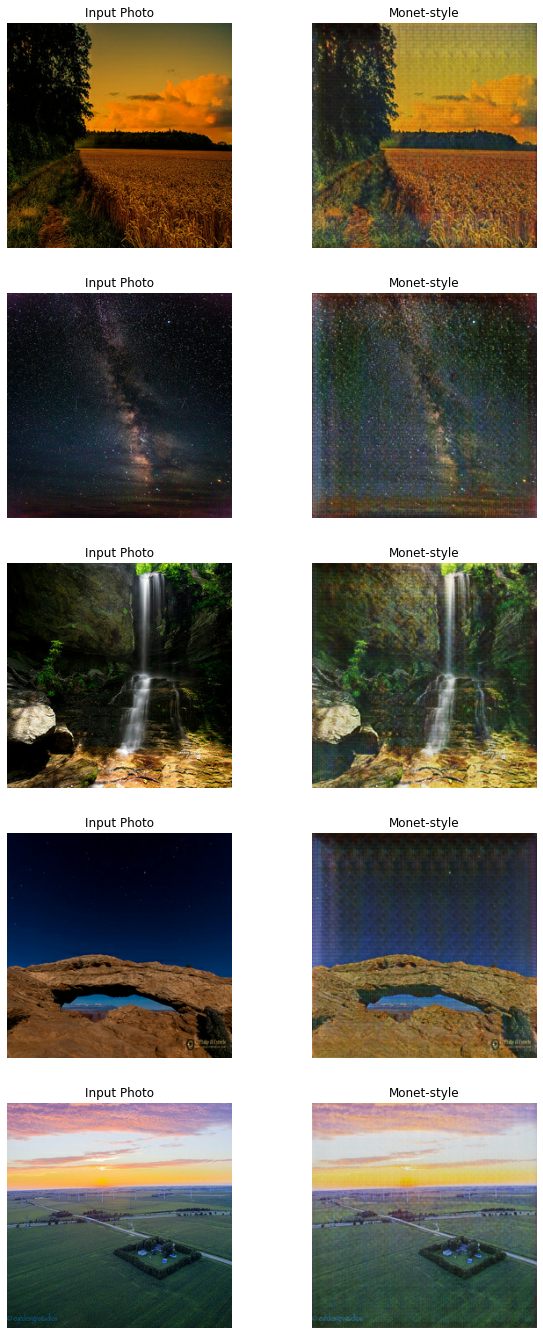

In [31]:
monet_generator = tf.keras.models.load_model('./saved_generator', compile=False)

_, ax = plt.subplots(5, 2, figsize=(10, 24))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-style")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

### Save as zip

In [ ]:
import PIL
import shutil
if os.path.exists('./ret_imgs') == False:
    os.mkdir('./ret_imgs')

i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("./ret_imgs/" + str(i) + ".jpg")
    i += 1
shutil.make_archive("./ret_imgs", 'zip', "./ret_imgs")

### Saliency map

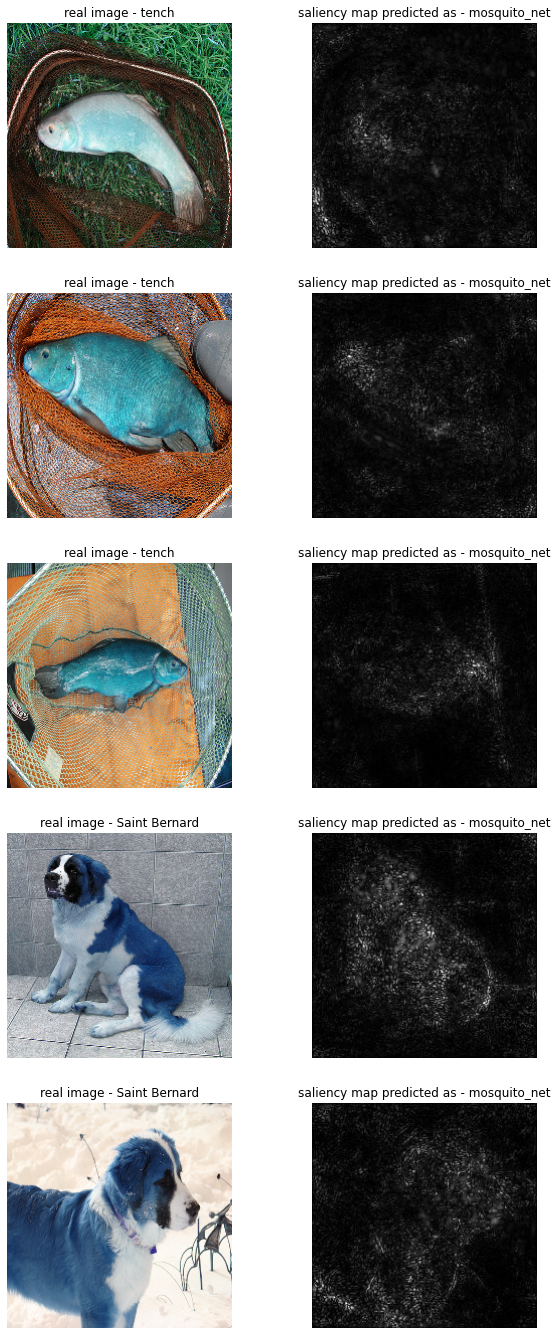

In [3]:
import matplotlib.pyplot as plt
from saliency import get_saliency_map
from dataLoader import get_saliency_data, imagenet_idx_to_label

imgs, labels = get_saliency_data(img_shape=(224, 224))
saliency_map, pred_rets = get_saliency_map(imgs, labels)
# print(pred_rets)
idx_map = imagenet_idx_to_label()

_, ax = plt.subplots(5, 2, figsize=(10, 24))
for idx in range(0, len(imgs[0:5])):
    img = imgs[idx]
    saliency_img =  saliency_map[idx]

    label = idx_map[labels[idx]]

    pred_label = pred_rets[idx][0][1]
    
    ax[idx, 0].imshow(img)
    ax[idx, 1].imshow(saliency_img, cmap='gray')
    ax[idx, 0].set_title(f"real image - {label}")
    ax[idx, 1].set_title(f"saliency map predicted as - {pred_label}")
    ax[idx, 0].axis("off")
    ax[idx, 1].axis("off")
plt.show()
